<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_7_Lipschitz_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title IMPORTs
import math
import os
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.optim.optimizer import Optimizer, required
from torch import Tensor
from torch.nn import Parameter
import torch.autograd as autograd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm 

plt.ion()
from IPython.display import clear_output

In [2]:
#@title HYPERPARAMETERS
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(n_epochs=200,
                     batch_size=64,
                     lr=.0002,
                     b1=.5,
                     b2=0.999,
                     n_cpu=8,
                     latent_dim=100,
                     img_size=32,
                     critics = 5,
                     channels= 1,
                     lambda_gp = 10,
                     sample_interval=400)

print(hp.lr)

0.0002


In [3]:
#@title SETUP & HELPERS
os.makedirs("images", exist_ok=True)

cuda = True if torch.cuda.is_available() else False

def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

def to_img(x):
  x = x.clamp(0, 1)
  return x

def show_image(img):
  img = to_img(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, x, y):
  with torch.no_grad():  
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = make_grid(images, x, y).numpy()
    figure(figsize=(20,20))
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

In [4]:
#@title SPECTRAL NORMALIZATION
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [5]:
#@title GENERATOR & DISCRIMINATOR
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.init_size = hp.img_size // 4
    self.l1 = nn.Sequential(nn.Linear(hp.latent_dim, 128 * self.init_size ** 2))

    self.conv_blocks = nn.Sequential(
      nn.BatchNorm2d(128),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 128, 3, stride=1, padding=1),
      nn.BatchNorm2d(128, 0.8),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, 3, stride=1, padding=1),
      nn.BatchNorm2d(64, 0.8),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(64, hp.channels, 3, stride=1, padding=1),
      nn.Tanh(),
    )

  def forward(self, z):
    out = self.l1(z)
    out = out.view(out.shape[0], 128, self.init_size, self.init_size)
    img = self.conv_blocks(out)
    return img

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def discriminator_block(in_filters, out_filters, bn=True):
      block = [SpectralNorm(nn.Conv2d(in_filters, out_filters, 3, 2, 1)), 
                nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
      if bn:
          block.append(nn.BatchNorm2d(out_filters, 0.8))
      return block

    self.model = nn.Sequential(
      *discriminator_block(hp.channels, 16, bn=False),
      *discriminator_block(16, 32),
      *discriminator_block(32, 64),
      *discriminator_block(64, 128),
    )

    # The height and width of downsampled image
    ds_size = hp.img_size // 2 ** 4
    self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

  def forward(self, img):
    out = self.model(img)
    out = out.view(out.shape[0], -1)
    validity = self.adv_layer(out)

    return validity

In [6]:
#@title LOSS & MODEL CREATION
loss_fn = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

if cuda:
  generator.cuda()
  discriminator.cuda()
  loss_fn.cuda()

# Initialize weights
#generator.apply(weights_init_normal)
#discriminator.apply(weights_init_normal)

In [7]:
#@title OPTIMIZERS and TENSOR SETUP
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [8]:
#@title HELPER FUNCTION - COMPUTE GRADIENT PENALTY
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(np.ones(d_interpolates.shape)), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [9]:
#@title LOAD DATA
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
  datasets.FashionMNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(hp.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
  ),
  batch_size=hp.batch_size,
  shuffle=True,
)

Epoch:51:It562:DLoss:0.9415814876556396:GLoss:0.5890032052993774


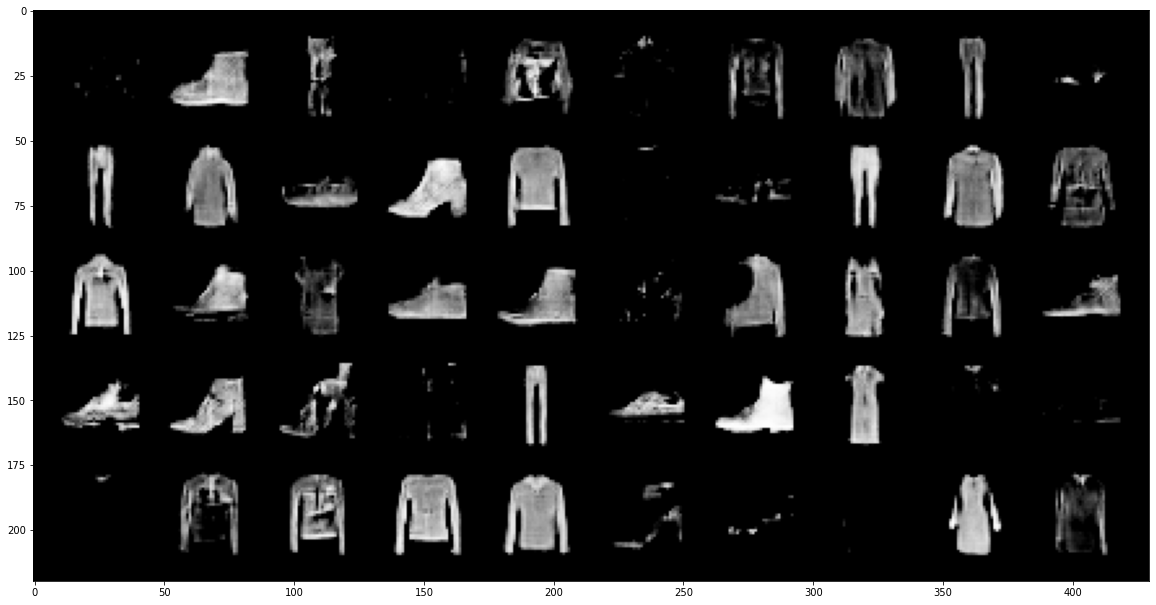

[Epoch 51/200] [Batch 651/938] [D loss: 1.068757] [G loss: 0.952953] ETA: 5:30:47.663939

In [ ]:
#@title TRAINING
start_time = time.time()
for epoch in range(hp.n_epochs):
  for i, (imgs, labels) in enumerate(dataloader):
      
      # Adversarial ground truths
      valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_imgs = Variable(imgs.type(Tensor))

      # -----------------
      #  Train Generator
      # -----------------

      optimizer_G.zero_grad()

      # Sample noise as generator input
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], hp.latent_dim))))

      # Generate a batch of images
      gen_imgs = generator(z)

      # Loss measures generator's ability to fool the discriminator
      loss_G = loss_fn(discriminator(gen_imgs), valid)

      loss_G.backward()
      optimizer_G.step()

      for _ in range(hp.critics):
          # ---------------------
          #  Train Discriminator
          # ---------------------
          optimizer_D.zero_grad()

          # Measure discriminator's ability to classify real from generated samples
          real_loss = loss_fn(discriminator(real_imgs), valid)
          fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake)
          # Gradient penalty
          gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, gen_imgs.data)
        
          loss_D = real_loss + fake_loss + hp.lambda_gp * gradient_penalty

          loss_D.backward()
          optimizer_D.step()

          batches_done = epoch * len(dataloader) + i
          batches_left = hp.n_epochs * len(dataloader) - batches_done
          time_left = datetime.timedelta(seconds=batches_left * (time.time() - start_time) / (batches_done + 1))

          # Print log
          sys.stdout.write(
              "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s"
              % (
                  epoch,
                  hp.n_epochs,
                  i,
                  len(dataloader),
                  loss_D.item(),                    
                  loss_G.item(),                    
                  time_left
              )
          )
      
      if batches_done % hp.sample_interval == 0:
        clear_output()
        print(f"Epoch:{epoch}:It{i}:DLoss:{loss_D.item()}:GLoss:{loss_G.item()}")          
        visualise_output(gen_imgs.data[:50],10, 10)
          #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)